In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

def generar_datos_fraude():
    """Genera dataset simulado de transacciones bancarias"""
    np.random.seed(42)

    # 10,000 transacciones (más manejable)
    total = 10000
    fraudes = 100  # 1% de fraude
    legit = total - fraudes

    # Transacciones legítimas
    datos_legit = {
        'monto': np.random.lognormal(6, 1, legit),
        'frecuencia': np.random.poisson(2, legit),
        'hora': np.random.normal(12, 4, legit),
        'dia_semana': np.random.choice(range(7), legit),
        'edad_cuenta': np.random.exponential(365, legit),
        'es_fraude': np.zeros(legit)
    }

    # Transacciones fraudulentas (patrones sospechosos)
    datos_fraude = {
        'monto': np.random.lognormal(8, 2, fraudes),     # Montos altos
        'frecuencia': np.random.poisson(5, fraudes),     # Alta frecuencia
        'hora': np.random.normal(2, 2, fraudes),         # Madrugada
        'dia_semana': np.random.choice([5, 6], fraudes), # Fin de semana
        'edad_cuenta': np.random.exponential(30, fraudes), # Cuentas nuevas
        'es_fraude': np.ones(fraudes)
    }

    # Combinar datos
    datos_final = {}
    for key in datos_legit.keys():
        datos_final[key] = np.concatenate([datos_legit[key], datos_fraude[key]])

    df = pd.DataFrame(datos_final)
    return df.sample(frac=1).reset_index(drop=True)

def entrenar_modelos(X_train, X_test, y_train, y_test):
    """Entrena y evalúa múltiples modelos"""

    modelos = {
        'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced'),
        'K-Neighbors': KNeighborsClassifier(n_neighbors=5),
        'SVM': SVC(kernel='rbf', random_state=42, class_weight='balanced'),
        'Naive Bayes': GaussianNB()
    }

    resultados = {}

    print("🔍 Entrenando modelos...")
    print("-" * 40)

    for nombre, modelo in modelos.items():
        # Entrenar
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # Evaluar
        resultados[nombre] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred, zero_division=0)
        }

        print(f"{nombre:<15} | F1: {resultados[nombre]['f1']:.3f} | "
              f"Recall: {resultados[nombre]['recall']:.3f}")

    return resultados, modelos

def mostrar_resultados(resultados):
    """Muestra resultados en tabla"""
    print("\n📊 RESULTADOS FINALES")
    print("=" * 60)
    print(f"{'Modelo':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-" * 60)

    for modelo, metricas in resultados.items():
        print(f"{modelo:<15} {metricas['accuracy']:<10.3f} "
              f"{metricas['precision']:<10.3f} {metricas['recall']:<10.3f} "
              f"{metricas['f1']:<10.3f}")

def predecir_fraude(modelo, nueva_transaccion):
    """Predice si una transacción es fraudulenta"""
    prediccion = modelo.predict([nueva_transaccion])[0]
    probabilidad = modelo.predict_proba([nueva_transaccion])[0][1]

    return prediccion, probabilidad

def main():
    """Función principal"""
    print("🏦 DETECTOR DE FRAUDE BANCARIO")
    print("=" * 40)

    # 1. Generar datos
    print("\n1️⃣ Generando datos...")
    df = generar_datos_fraude()

    fraudes = len(df[df['es_fraude'] == 1])
    legit = len(df[df['es_fraude'] == 0])

    print(f"   📊 Total: {len(df):,} transacciones")
    print(f"   ✅ Legítimas: {legit:,}")
    print(f"   🚨 Fraudulentas: {fraudes:,}")
    print(f"   📈 % Fraude: {(fraudes/len(df)*100):.1f}%")

    # 2. Preparar datos
    print("\n2️⃣ Preparando datos...")
    X = df.drop('es_fraude', axis=1)
    y = df['es_fraude']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print(f"   🔧 Entrenamiento: {len(X_train):,}")
    print(f"   🧪 Prueba: {len(X_test):,}")

    # 3. Entrenar modelos
    print("\n3️⃣ Entrenando modelos...")
    resultados, modelos = entrenar_modelos(X_train, X_test, y_train, y_test)

    # 4. Mostrar resultados
    mostrar_resultados(resultados)

    # 5. Encontrar mejor modelo
    mejor_modelo = max(resultados, key=lambda x: resultados[x]['f1'])
    print(f"\n🏆 Mejor modelo: {mejor_modelo}")

    # 6. Ejemplo de predicción
    print("\n🔮 EJEMPLO DE PREDICCIÓN")
    print("-" * 30)

    # Transacción sospechosa
    transaccion_sospechosa = [8000, 5, 3, 6, 10]  # monto alto, frecuente, madrugada, fin de semana, cuenta nueva

    modelo_rf = modelos[mejor_modelo]
    prediccion, probabilidad = predecir_fraude(modelo_rf, transaccion_sospechosa)

    print(f"🔍 Transacción:")
    print(f"   • Monto: ${transaccion_sospechosa[0]:,}")
    print(f"   • Frecuencia: {transaccion_sospechosa[1]}")
    print(f"   • Hora: {transaccion_sospechosa[2]}:00")
    print(f"   • Día: {'Fin de semana' if transaccion_sospechosa[3] >= 5 else 'Entre semana'}")
    print(f"   • Edad cuenta: {transaccion_sospechosa[4]} días")

    print(f"\n🎯 Resultado: {'🚨 FRAUDE' if prediccion == 1 else '✅ LEGÍTIMA'}")
    print(f"📊 Probabilidad fraude: {probabilidad:.1%}")

    # Recomendación
    if probabilidad > 0.7:
        print("⚠️  ACCIÓN: Bloquear transacción")
    elif probabilidad > 0.3:
        print("🔍 ACCIÓN: Revisar manualmente")
    else:
        print("✅ ACCIÓN: Aprobar transacción")

if __name__ == "__main__":
    main()

🏦 DETECTOR DE FRAUDE BANCARIO

1️⃣ Generando datos...
   📊 Total: 10,000 transacciones
   ✅ Legítimas: 9,900
   🚨 Fraudulentas: 100
   📈 % Fraude: 1.0%

2️⃣ Preparando datos...
   🔧 Entrenamiento: 7,000
   🧪 Prueba: 3,000

3️⃣ Entrenando modelos...
🔍 Entrenando modelos...
----------------------------------------
Random Forest   | F1: 0.893 | Recall: 0.833
K-Neighbors     | F1: 0.431 | Recall: 0.367
SVM             | F1: 0.164 | Recall: 0.933
Naive Bayes     | F1: 0.833 | Recall: 0.833

📊 RESULTADOS FINALES
Modelo          Accuracy   Precision  Recall     F1-Score  
------------------------------------------------------------
Random Forest   0.998      0.962      0.833      0.893     
K-Neighbors     0.990      0.524      0.367      0.431     
SVM             0.905      0.090      0.933      0.164     
Naive Bayes     0.997      0.833      0.833      0.833     

🏆 Mejor modelo: Random Forest

🔮 EJEMPLO DE PREDICCIÓN
------------------------------
🔍 Transacción:
   • Monto: $8,000
   • F

🏦 DETECTOR DE FRAUDE BANCARIO

1️⃣ Generando datos...
   📊 Total: 10,000 transacciones
   ✅ Legítimas: 9,900
   🚨 Fraudulentas: 100
   📈 % Fraude: 1.0%

2️⃣ Preparando datos...
   🔧 Entrenamiento: 7,000
   🧪 Prueba: 3,000

3️⃣ Entrenando modelos...
🔍 Entrenando modelos...
----------------------------------------
Random Forest   | F1: 0.893 | Recall: 0.833
K-Neighbors     | F1: 0.431 | Recall: 0.367
SVM             | F1: 0.164 | Recall: 0.933
Naive Bayes     | F1: 0.833 | Recall: 0.833

📊 RESULTADOS FINALES
Modelo          Accuracy   Precision  Recall     F1-Score  
------------------------------------------------------------
Random Forest   0.998      0.962      0.833      0.893     
K-Neighbors     0.990      0.524      0.367      0.431     
SVM             0.905      0.090      0.933      0.164     
Naive Bayes     0.997      0.833      0.833      0.833     

5️⃣ Generando gráficos comparativos...


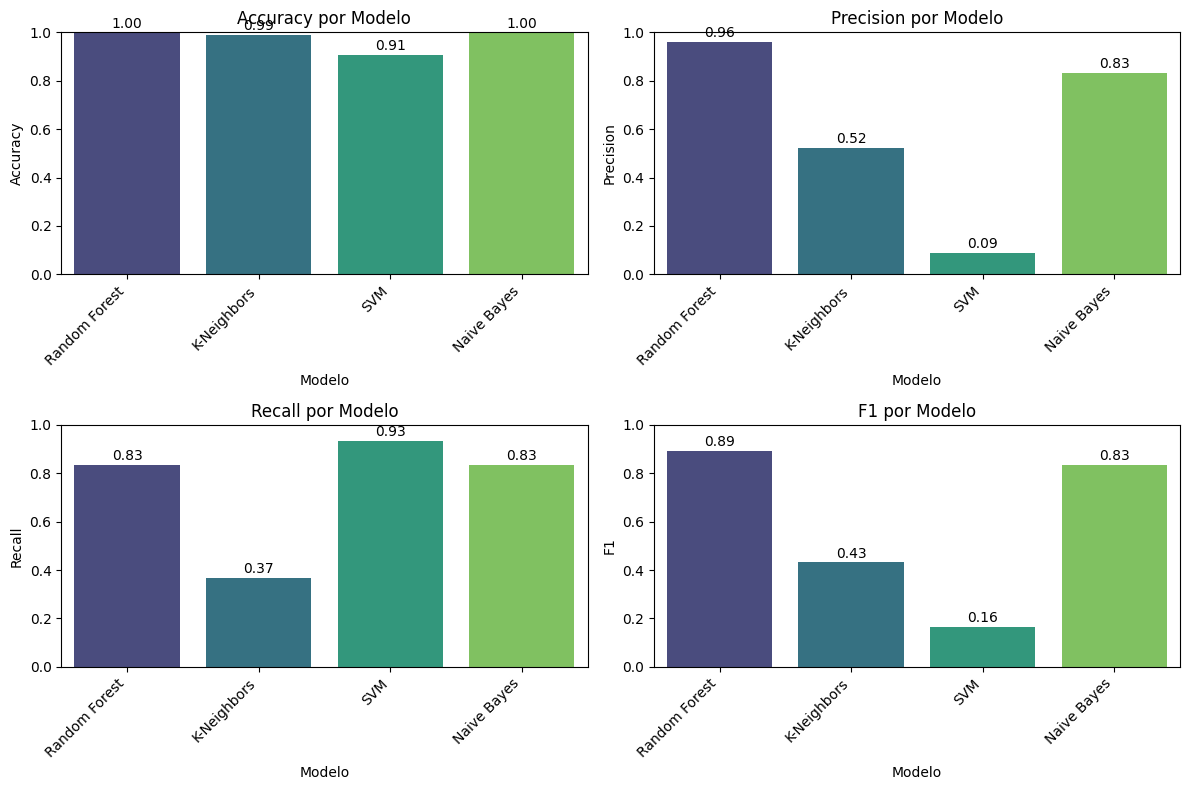


🏆 Mejor modelo (basado en F1-Score): Random Forest

🔮 EJEMPLO DE PREDICCIÓN
------------------------------
🔍 Transacción:
   • Monto: $8,000
   • Frecuencia: 5
   • Hora: 3:00
   • Día: Fin de semana
   • Edad cuenta: 10 días

🎯 Resultado: 🚨 FRAUDE
📊 Probabilidad fraude: 100.0%
⚠️  ACCIÓN: Bloquear transacción


In [2]:
# prompt: genera gráficas comparativas de los resultados del modelo

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def graficar_resultados(resultados):
    """Genera gráficos comparativos de los resultados del modelo"""
    metricas = ['accuracy', 'precision', 'recall', 'f1']
    df_resultados = pd.DataFrame(resultados).T

    plt.figure(figsize=(12, 8))

    for i, metrica in enumerate(metricas):
        plt.subplot(2, 2, i + 1)
        sns.barplot(x=df_resultados.index, y=df_resultados[metrica], palette='viridis')
        plt.title(f'{metrica.capitalize()} por Modelo')
        plt.ylabel(metrica.capitalize())
        plt.xlabel('Modelo')
        plt.ylim(0, 1) # Asegura que el eje Y vaya de 0 a 1 para métricas de 0 a 1
        plt.xticks(rotation=45, ha='right')

        # Añadir valores en las barras
        for index, value in enumerate(df_resultados[metrica]):
            plt.text(index, value + 0.02, f'{value:.2f}', ha='center')


    plt.tight_layout()
    plt.show()

def main():
    """Función principal"""
    print("🏦 DETECTOR DE FRAUDE BANCARIO")
    print("=" * 40)

    # 1. Generar datos
    print("\n1️⃣ Generando datos...")
    df = generar_datos_fraude()

    fraudes = len(df[df['es_fraude'] == 1])
    legit = len(df[df['es_fraude'] == 0])

    print(f"   📊 Total: {len(df):,} transacciones")
    print(f"   ✅ Legítimas: {legit:,}")
    print(f"   🚨 Fraudulentas: {fraudes:,}")
    print(f"   📈 % Fraude: {(fraudes/len(df)*100):.1f}%")

    # 2. Preparar datos
    print("\n2️⃣ Preparando datos...")
    X = df.drop('es_fraude', axis=1)
    y = df['es_fraude']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print(f"   🔧 Entrenamiento: {len(X_train):,}")
    print(f"   🧪 Prueba: {len(X_test):,}")

    # 3. Entrenar modelos
    print("\n3️⃣ Entrenando modelos...")
    resultados, modelos = entrenar_modelos(X_train, X_test, y_train, y_test)

    # 4. Mostrar resultados
    mostrar_resultados(resultados)

    # 5. Generar gráficos comparativos
    print("\n5️⃣ Generando gráficos comparativos...")
    graficar_resultados(resultados)

    # 6. Encontrar mejor modelo
    mejor_modelo = max(resultados, key=lambda x: resultados[x]['f1'])
    print(f"\n🏆 Mejor modelo (basado en F1-Score): {mejor_modelo}")

    # 7. Ejemplo de predicción
    print("\n🔮 EJEMPLO DE PREDICCIÓN")
    print("-" * 30)

    # Transacción sospechosa
    transaccion_sospechosa = [8000, 5, 3, 6, 10]  # monto alto, frecuente, madrugada, fin de semana, cuenta nueva

    modelo_rf = modelos[mejor_modelo]
    prediccion, probabilidad = predecir_fraude(modelo_rf, transaccion_sospechosa)

    print(f"🔍 Transacción:")
    print(f"   • Monto: ${transaccion_sospechosa[0]:,}")
    print(f"   • Frecuencia: {transaccion_sospechosa[1]}")
    print(f"   • Hora: {transaccion_sospechosa[2]}:00")
    print(f"   • Día: {'Fin de semana' if transaccion_sospechosa[3] >= 5 else 'Entre semana'}")
    print(f"   • Edad cuenta: {transaccion_sospechosa[4]} días")

    print(f"\n🎯 Resultado: {'🚨 FRAUDE' if prediccion == 1 else '✅ LEGÍTIMA'}")
    print(f"📊 Probabilidad fraude: {probabilidad:.1%}")

    # Recomendación
    if probabilidad > 0.7:
        print("⚠️  ACCIÓN: Bloquear transacción")
    elif probabilidad > 0.3:
        print("🔍 ACCIÓN: Revisar manualmente")
    else:
        print("✅ ACCIÓN: Aprobar transacción")

if __name__ == "__main__":
    main()


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           matthews_corrcoef, confusion_matrix, classification_report)
import warnings
warnings.filterwarnings('ignore')

def generar_datos_fraude():
    """Genera dataset simulado de transacciones bancarias"""
    np.random.seed(42)

    total = 10000
    fraudes = 100
    legit = total - fraudes

    # Transacciones legítimas
    datos_legit = {
        'monto': np.random.lognormal(6, 1, legit),
        'frecuencia': np.random.poisson(2, legit),
        'hora': np.random.normal(12, 4, legit),
        'dia_semana': np.random.choice(range(7), legit),
        'edad_cuenta': np.random.exponential(365, legit),
        'es_fraude': np.zeros(legit)
    }

    # Transacciones fraudulentas
    datos_fraude = {
        'monto': np.random.lognormal(8, 2, fraudes),
        'frecuencia': np.random.poisson(5, fraudes),
        'hora': np.random.normal(2, 2, fraudes),
        'dia_semana': np.random.choice([5, 6], fraudes),
        'edad_cuenta': np.random.exponential(30, fraudes),
        'es_fraude': np.ones(fraudes)
    }

    # Combinar datos
    datos_final = {}
    for key in datos_legit.keys():
        datos_final[key] = np.concatenate([datos_legit[key], datos_fraude[key]])

    df = pd.DataFrame(datos_final)
    return df.sample(frac=1).reset_index(drop=True)

def calcular_metricas_detalladas(y_true, y_pred, nombre_modelo):
    """Calcula todas las métricas de evaluación para un modelo"""

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Métricas básicas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)

    # Métricas adicionales
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate

    # Balanced Accuracy
    balanced_acc = (recall + specificity) / 2

    return {
        'modelo': nombre_modelo,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,
        'npv': npv,
        'mcc': mcc,
        'balanced_accuracy': balanced_acc,
        'fpr': fpr,
        'fnr': fnr,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn
    }

def mostrar_metricas_completas(resultados_metricas):
    """Muestra todas las métricas de forma detallada"""

    print("📊 MÉTRICAS COMPLETAS DE EVALUACIÓN")
    print("=" * 80)

    # 1. Tabla de métricas principales
    print("\n1️⃣ MÉTRICAS PRINCIPALES")
    print("-" * 50)
    print(f"{'Modelo':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-" * 50)

    for resultado in resultados_metricas:
        print(f"{resultado['modelo']:<15} {resultado['accuracy']:<10.3f} "
              f"{resultado['precision']:<10.3f} {resultado['recall']:<10.3f} "
              f"{resultado['f1_score']:<10.3f}")

    # 2. Métricas avanzadas
    print("\n2️⃣ MÉTRICAS AVANZADAS")
    print("-" * 65)
    print(f"{'Modelo':<15} {'Specificity':<12} {'NPV':<10} {'MCC':<10} {'Bal.Acc':<10}")
    print("-" * 65)

    for resultado in resultados_metricas:
        print(f"{resultado['modelo']:<15} {resultado['specificity']:<12.3f} "
              f"{resultado['npv']:<10.3f} {resultado['mcc']:<10.3f} "
              f"{resultado['balanced_accuracy']:<10.3f}")

    # 3. Tasas de error
    print("\n3️⃣ TASAS DE ERROR")
    print("-" * 40)
    print(f"{'Modelo':<15} {'FPR':<10} {'FNR':<10}")
    print("-" * 40)

    for resultado in resultados_metricas:
        print(f"{resultado['modelo']:<15} {resultado['fpr']:<10.3f} "
              f"{resultado['fnr']:<10.3f}")

    # 4. Matriz de confusión para cada modelo
    print("\n4️⃣ MATRICES DE CONFUSIÓN")
    print("-" * 30)

    for resultado in resultados_metricas:
        print(f"\n🔍 {resultado['modelo']}")
        print(f"   Verdaderos Positivos (TP): {resultado['tp']}")
        print(f"   Verdaderos Negativos (TN): {resultado['tn']}")
        print(f"   Falsos Positivos (FP): {resultado['fp']}")
        print(f"   Falsos Negativos (FN): {resultado['fn']}")
        print(f"   Total predicciones correctas: {resultado['tp'] + resultado['tn']}")
        print(f"   Total predicciones incorrectas: {resultado['fp'] + resultado['fn']}")

def mostrar_interpretacion_metricas():
    """Muestra interpretación de cada métrica"""

    print("\n📖 INTERPRETACIÓN DE MÉTRICAS")
    print("=" * 50)

    interpretaciones = {
        "Accuracy": "Porcentaje de predicciones correctas del total",
        "Precision": "De las predicciones de fraude, cuántas fueron correctas",
        "Recall": "De todos los fraudes reales, cuántos fueron detectados",
        "F1-Score": "Media armónica entre precisión y recall",
        "Specificity": "De todas las transacciones legítimas, cuántas fueron correctamente clasificadas",
        "NPV": "De las predicciones de legítimas, cuántas fueron correctas",
        "MCC": "Coeficiente de correlación de Matthews (-1 a 1, mejor cerca de 1)",
        "Balanced Accuracy": "Promedio entre recall y specificity",
        "FPR": "Tasa de falsos positivos (alarmas falsas)",
        "FNR": "Tasa de falsos negativos (fraudes no detectados)"
    }

    for metrica, interpretacion in interpretaciones.items():
        print(f"• {metrica:<18}: {interpretacion}")

def analizar_rendimiento_por_modelo(resultados_metricas):
    """Analiza el rendimiento de cada modelo"""

    print("\n🎯 ANÁLISIS DE RENDIMIENTO")
    print("=" * 40)

    # Encontrar el mejor modelo para cada métrica
    mejor_accuracy = max(resultados_metricas, key=lambda x: x['accuracy'])
    mejor_precision = max(resultados_metricas, key=lambda x: x['precision'])
    mejor_recall = max(resultados_metricas, key=lambda x: x['recall'])
    mejor_f1 = max(resultados_metricas, key=lambda x: x['f1_score'])

    print(f"🏆 Mejor Accuracy: {mejor_accuracy['modelo']} ({mejor_accuracy['accuracy']:.3f})")
    print(f"🎯 Mejor Precision: {mejor_precision['modelo']} ({mejor_precision['precision']:.3f})")
    print(f"🔍 Mejor Recall: {mejor_recall['modelo']} ({mejor_recall['recall']:.3f})")
    print(f"⚖️  Mejor F1-Score: {mejor_f1['modelo']} ({mejor_f1['f1_score']:.3f})")

    # Análisis de trade-offs
    print("\n📊 ANÁLISIS DE TRADE-OFFS")
    print("-" * 30)

    for resultado in resultados_metricas:
        modelo = resultado['modelo']
        precision = resultado['precision']
        recall = resultado['recall']
        fpr = resultado['fpr']

        print(f"\n{modelo}:")

        if precision > 0.8 and recall > 0.8:
            print("   ✅ Excelente balance precision-recall")
        elif precision > 0.8:
            print("   🎯 Alta precisión (pocas alarmas falsas)")
        elif recall > 0.8:
            print("   🔍 Alto recall (detecta la mayoría de fraudes)")
        else:
            print("   ⚠️  Necesita mejora en precision y/o recall")

        if fpr < 0.01:
            print("   ✅ Muy pocas alarmas falsas")
        elif fpr < 0.05:
            print("   👍 Alarmas falsas aceptables")
        else:
            print("   ❌ Demasiadas alarmas falsas")

def main():
    """Función principal con análisis detallado de métricas"""

    print("🏦 ANÁLISIS DETALLADO DE MÉTRICAS - DETECTOR DE FRAUDE")
    print("=" * 60)

    # Generar datos
    df = generar_datos_fraude()
    X = df.drop('es_fraude', axis=1)
    y = df['es_fraude']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Modelos a evaluar
    modelos = {
        'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced'),
        'K-Neighbors': KNeighborsClassifier(n_neighbors=5),
        'SVM': SVC(kernel='rbf', random_state=42, class_weight='balanced'),
        'Naive Bayes': GaussianNB()
    }

    # Entrenar y evaluar cada modelo
    resultados_metricas = []

    print("\n🔍 Entrenando y evaluando modelos...")

    for nombre, modelo in modelos.items():
        print(f"   Procesando {nombre}...")

        # Entrenar
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # Calcular métricas
        metricas = calcular_metricas_detalladas(y_test, y_pred, nombre)
        resultados_metricas.append(metricas)

    # Mostrar resultados detallados
    mostrar_metricas_completas(resultados_metricas)

    # Mostrar interpretación
    mostrar_interpretacion_metricas()

    # Análisis de rendimiento
    analizar_rendimiento_por_modelo(resultados_metricas)

    print("\n" + "="*60)
    print("✅ Análisis completo terminado")

if __name__ == "__main__":
    main()

🏦 ANÁLISIS DETALLADO DE MÉTRICAS - DETECTOR DE FRAUDE

🔍 Entrenando y evaluando modelos...
   Procesando Random Forest...
   Procesando K-Neighbors...
   Procesando SVM...
   Procesando Naive Bayes...
📊 MÉTRICAS COMPLETAS DE EVALUACIÓN

1️⃣ MÉTRICAS PRINCIPALES
--------------------------------------------------
Modelo          Accuracy   Precision  Recall     F1-Score  
--------------------------------------------------
Random Forest   0.998      0.962      0.833      0.893     
K-Neighbors     0.990      0.524      0.367      0.431     
SVM             0.905      0.090      0.933      0.164     
Naive Bayes     0.997      0.833      0.833      0.833     

2️⃣ MÉTRICAS AVANZADAS
-----------------------------------------------------------------
Modelo          Specificity  NPV        MCC        Bal.Acc   
-----------------------------------------------------------------
Random Forest   1.000        0.998      0.894      0.916     
K-Neighbors     0.997        0.994      0.434      0.682

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           matthews_corrcoef, confusion_matrix, classification_report)
import warnings
warnings.filterwarnings('ignore')

def generar_datos_fraude():
    """Genera dataset simulado de transacciones bancarias"""
    np.random.seed(42)

    total = 10000
    fraudes = 100
    legit = total - fraudes

    # Transacciones legítimas
    datos_legit = {
        'monto': np.random.lognormal(6, 1, legit),
        'frecuencia': np.random.poisson(2, legit),
        'hora': np.random.normal(12, 4, legit),
        'dia_semana': np.random.choice(range(7), legit),
        'edad_cuenta': np.random.exponential(365, legit),
        'es_fraude': np.zeros(legit)
    }

    # Transacciones fraudulentas
    datos_fraude = {
        'monto': np.random.lognormal(8, 2, fraudes),
        'frecuencia': np.random.poisson(5, fraudes),
        'hora': np.random.normal(2, 2, fraudes),
        'dia_semana': np.random.choice([5, 6], fraudes),
        'edad_cuenta': np.random.exponential(30, fraudes),
        'es_fraude': np.ones(fraudes)
    }

    # Combinar datos
    datos_final = {}
    for key in datos_legit.keys():
        datos_final[key] = np.concatenate([datos_legit[key], datos_fraude[key]])

    df = pd.DataFrame(datos_final)
    return df.sample(frac=1).reset_index(drop=True)

def calcular_metricas_detalladas(y_true, y_pred, nombre_modelo):
    """Calcula todas las métricas de evaluación para un modelo"""

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Métricas básicas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)

    # Métricas adicionales
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate

    # Balanced Accuracy
    balanced_acc = (recall + specificity) / 2

    return {
        'modelo': nombre_modelo,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,
        'npv': npv,
        'mcc': mcc,
        'balanced_accuracy': balanced_acc,
        'fpr': fpr,
        'fnr': fnr,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn
    }

def mostrar_metricas_completas(resultados_metricas):
    """Muestra todas las métricas de forma detallada"""

    print("📊 MÉTRICAS COMPLETAS DE EVALUACIÓN")
    print("=" * 80)

    # 1. Tabla de métricas principales
    print("\n1️⃣ MÉTRICAS PRINCIPALES")
    print("-" * 50)
    print(f"{'Modelo':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-" * 50)

    for resultado in resultados_metricas:
        print(f"{resultado['modelo']:<15} {resultado['accuracy']:<10.3f} "
              f"{resultado['precision']:<10.3f} {resultado['recall']:<10.3f} "
              f"{resultado['f1_score']:<10.3f}")

    # 2. Métricas avanzadas
    print("\n2️⃣ MÉTRICAS AVANZADAS")
    print("-" * 65)
    print(f"{'Modelo':<15} {'Specificity':<12} {'NPV':<10} {'MCC':<10} {'Bal.Acc':<10}")
    print("-" * 65)

    for resultado in resultados_metricas:
        print(f"{resultado['modelo']:<15} {resultado['specificity']:<12.3f} "
              f"{resultado['npv']:<10.3f} {resultado['mcc']:<10.3f} "
              f"{resultado['balanced_accuracy']:<10.3f}")

    # 3. Tasas de error
    print("\n3️⃣ TASAS DE ERROR")
    print("-" * 40)
    print(f"{'Modelo':<15} {'FPR':<10} {'FNR':<10}")
    print("-" * 40)

    for resultado in resultados_metricas:
        print(f"{resultado['modelo']:<15} {resultado['fpr']:<10.3f} "
              f"{resultado['fnr']:<10.3f}")

    # 4. Matriz de confusión para cada modelo
    print("\n4️⃣ MATRICES DE CONFUSIÓN")
    print("-" * 30)

    for resultado in resultados_metricas:
        print(f"\n🔍 {resultado['modelo']}")
        print(f"   Verdaderos Positivos (TP): {resultado['tp']}")
        print(f"   Verdaderos Negativos (TN): {resultado['tn']}")
        print(f"   Falsos Positivos (FP): {resultado['fp']}")
        print(f"   Falsos Negativos (FN): {resultado['fn']}")
        print(f"   Total predicciones correctas: {resultado['tp'] + resultado['tn']}")
        print(f"   Total predicciones incorrectas: {resultado['fp'] + resultado['fn']}")

def mostrar_interpretacion_metricas():
    """Muestra interpretación de cada métrica"""

    print("\n📖 INTERPRETACIÓN DE MÉTRICAS")
    print("=" * 50)

    interpretaciones = {
        "Accuracy": "Porcentaje de predicciones correctas del total",
        "Precision": "De las predicciones de fraude, cuántas fueron correctas",
        "Recall": "De todos los fraudes reales, cuántos fueron detectados",
        "F1-Score": "Media armónica entre precisión y recall",
        "Specificity": "De todas las transacciones legítimas, cuántas fueron correctamente clasificadas",
        "NPV": "De las predicciones de legítimas, cuántas fueron correctas",
        "MCC": "Coeficiente de correlación de Matthews (-1 a 1, mejor cerca de 1)",
        "Balanced Accuracy": "Promedio entre recall y specificity",
        "FPR": "Tasa de falsos positivos (alarmas falsas)",
        "FNR": "Tasa de falsos negativos (fraudes no detectados)"
    }

    for metrica, interpretacion in interpretaciones.items():
        print(f"• {metrica:<18}: {interpretacion}")

def analizar_rendimiento_por_modelo(resultados_metricas):
    """Analiza el rendimiento de cada modelo"""

    print("\n🎯 ANÁLISIS DE RENDIMIENTO")
    print("=" * 40)

    # Encontrar el mejor modelo para cada métrica
    mejor_accuracy = max(resultados_metricas, key=lambda x: x['accuracy'])
    mejor_precision = max(resultados_metricas, key=lambda x: x['precision'])
    mejor_recall = max(resultados_metricas, key=lambda x: x['recall'])
    mejor_f1 = max(resultados_metricas, key=lambda x: x['f1_score'])

    print(f"🏆 Mejor Accuracy: {mejor_accuracy['modelo']} ({mejor_accuracy['accuracy']:.3f})")
    print(f"🎯 Mejor Precision: {mejor_precision['modelo']} ({mejor_precision['precision']:.3f})")
    print(f"🔍 Mejor Recall: {mejor_recall['modelo']} ({mejor_recall['recall']:.3f})")
    print(f"⚖️  Mejor F1-Score: {mejor_f1['modelo']} ({mejor_f1['f1_score']:.3f})")

    # Análisis de trade-offs
    print("\n📊 ANÁLISIS DE TRADE-OFFS")
    print("-" * 30)

    for resultado in resultados_metricas:
        modelo = resultado['modelo']
        precision = resultado['precision']
        recall = resultado['recall']
        fpr = resultado['fpr']

        print(f"\n{modelo}:")

        if precision > 0.8 and recall > 0.8:
            print("   ✅ Excelente balance precision-recall")
        elif precision > 0.8:
            print("   🎯 Alta precisión (pocas alarmas falsas)")
        elif recall > 0.8:
            print("   🔍 Alto recall (detecta la mayoría de fraudes)")
        else:
            print("   ⚠️  Necesita mejora en precision y/o recall")

        if fpr < 0.01:
            print("   ✅ Muy pocas alarmas falsas")
        elif fpr < 0.05:
            print("   👍 Alarmas falsas aceptables")
        else:
            print("   ❌ Demasiadas alarmas falsas")

def main():
    """Función principal con análisis detallado de métricas"""

    print("🏦 ANÁLISIS DETALLADO DE MÉTRICAS - DETECTOR DE FRAUDE")
    print("=" * 60)

    # Generar datos
    df = generar_datos_fraude()
    X = df.drop('es_fraude', axis=1)
    y = df['es_fraude']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Modelos a evaluar
    modelos = {
        'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced'),
        'K-Neighbors': KNeighborsClassifier(n_neighbors=5),
        'SVM': SVC(kernel='rbf', random_state=42, class_weight='balanced'),
        'Naive Bayes': GaussianNB()
    }

    # Entrenar y evaluar cada modelo
    resultados_metricas = []

    print("\n🔍 Entrenando y evaluando modelos...")

    for nombre, modelo in modelos.items():
        print(f"   Procesando {nombre}...")

        # Entrenar
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # Calcular métricas
        metricas = calcular_metricas_detalladas(y_test, y_pred, nombre)
        resultados_metricas.append(metricas)

    # Mostrar resultados detallados
    mostrar_metricas_completas(resultados_metricas)

    # Mostrar interpretación
    mostrar_interpretacion_metricas()

    # Análisis de rendimiento
    analizar_rendimiento_por_modelo(resultados_metricas)

    print("\n" + "="*60)
    print("✅ Análisis completo terminado")

if __name__ == "__main__":
    main()

🏦 ANÁLISIS DETALLADO DE MÉTRICAS - DETECTOR DE FRAUDE

🔍 Entrenando y evaluando modelos...
   Procesando Random Forest...
   Procesando K-Neighbors...
   Procesando SVM...
   Procesando Naive Bayes...
📊 MÉTRICAS COMPLETAS DE EVALUACIÓN

1️⃣ MÉTRICAS PRINCIPALES
--------------------------------------------------
Modelo          Accuracy   Precision  Recall     F1-Score  
--------------------------------------------------
Random Forest   0.998      0.962      0.833      0.893     
K-Neighbors     0.990      0.524      0.367      0.431     
SVM             0.905      0.090      0.933      0.164     
Naive Bayes     0.997      0.833      0.833      0.833     

2️⃣ MÉTRICAS AVANZADAS
-----------------------------------------------------------------
Modelo          Specificity  NPV        MCC        Bal.Acc   
-----------------------------------------------------------------
Random Forest   1.000        0.998      0.894      0.916     
K-Neighbors     0.997        0.994      0.434      0.682

🏦 ANÁLISIS DETALLADO DE MÉTRICAS Y GRÁFICOS - DETECTOR DE FRAUDE

🔍 Entrenando y evaluando modelos...
   Procesando Random Forest...
   Procesando K-Neighbors...
   Procesando SVM...
   Procesando Naive Bayes...
📊 MÉTRICAS COMPLETAS DE EVALUACIÓN

1️⃣ MÉTRICAS PRINCIPALES
--------------------------------------------------
Modelo          Accuracy   Precision  Recall     F1-Score  
--------------------------------------------------
Random Forest   0.998      0.962      0.833      0.893     
K-Neighbors     0.990      0.524      0.367      0.431     
SVM             0.905      0.090      0.933      0.164     
Naive Bayes     0.997      0.833      0.833      0.833     

2️⃣ MÉTRICAS AVANZADAS
-----------------------------------------------------------------
Modelo          Specificity  NPV        MCC        Bal.Acc   
-----------------------------------------------------------------
Random Forest   1.000        0.998      0.894      0.916     
K-Neighbors     0.997        0.994      0.434

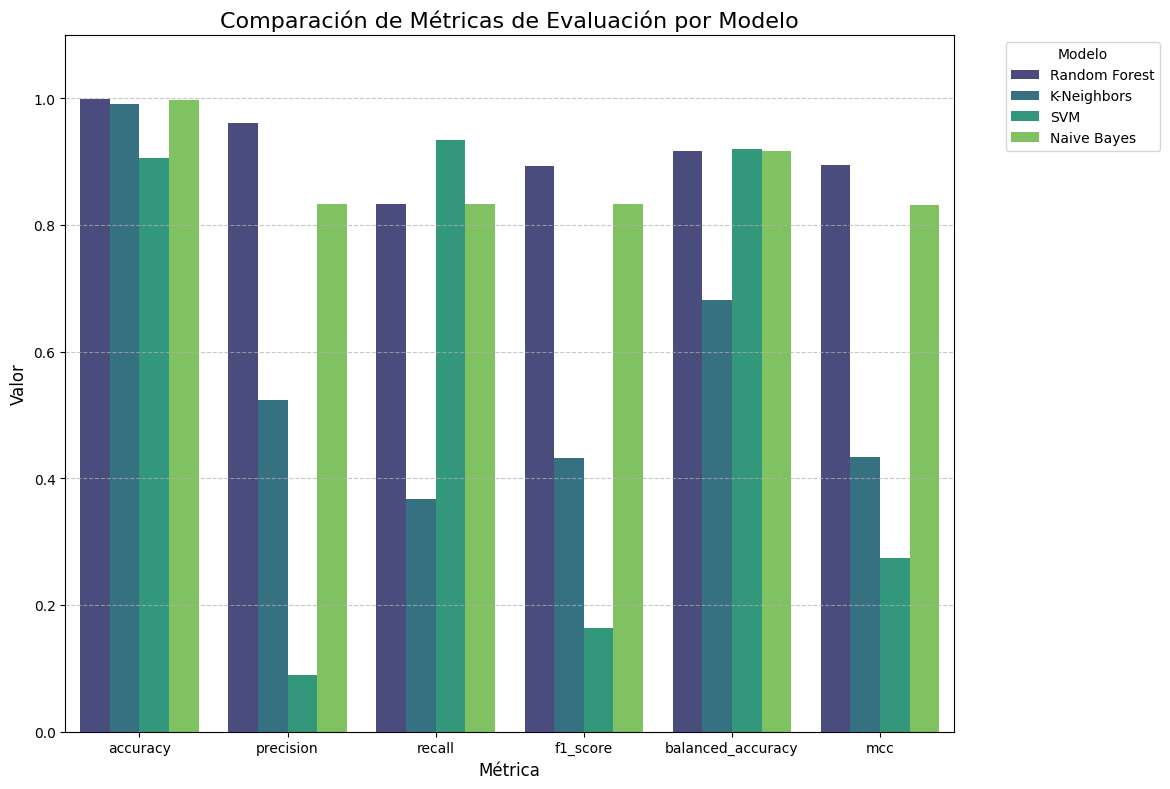

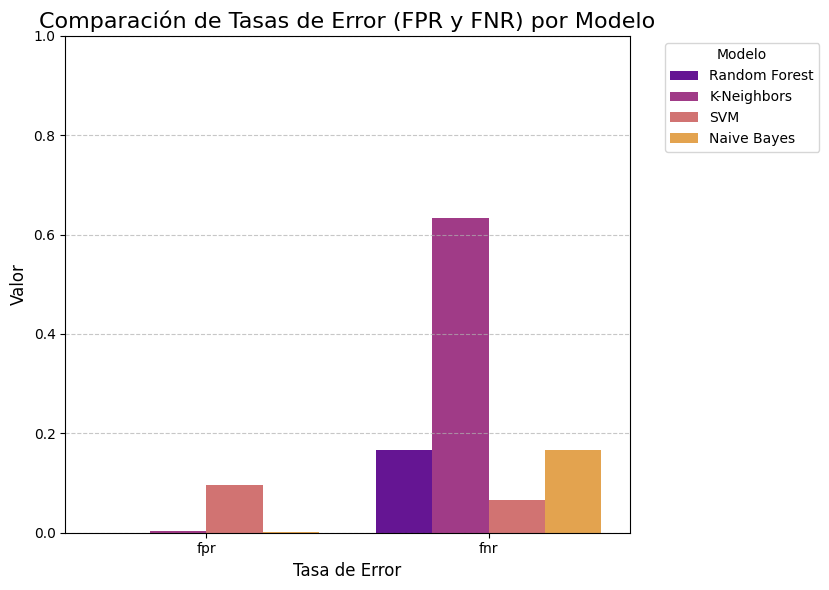


✅ Análisis y visualización completos terminados


In [7]:
# prompt: genera gráficas de las mértricas de evaluación

import pandas as pd
import matplotlib.pyplot as plt
def graficar_metricas_comparacion(resultados_metricas):
    """Genera gráficos comparativos de las métricas de evaluación para diferentes modelos."""

    # Convertir la lista de diccionarios a un DataFrame para facilitar la graficación
    df_metricas = pd.DataFrame(resultados_metricas)
    df_metricas = df_metricas.set_index('modelo') # Usar el nombre del modelo como índice

    # Seleccionar las métricas clave para graficar
    metricas_clave = ['accuracy', 'precision', 'recall', 'f1_score', 'balanced_accuracy', 'mcc']
    df_metricas_clave = df_metricas[metricas_clave]

    # Reorganizar los datos para un gráfico de barras agrupadas
    df_metricas_melted = df_metricas_clave.reset_index().melt(
        id_vars='modelo', var_name='metrica', value_name='valor'
    )

    plt.figure(figsize=(14, 8))
    sns.barplot(data=df_metricas_melted, x='metrica', y='valor', hue='modelo', palette='viridis')

    plt.title('Comparación de Métricas de Evaluación por Modelo', fontsize=16)
    plt.xlabel('Métrica', fontsize=12)
    plt.ylabel('Valor', fontsize=12)
    plt.ylim(0, 1.1) # Establecer el límite superior para métricas entre 0 y 1
    plt.xticks(rotation=0) # Rotación de 0 grados para las métricas

    # Ajustar la leyenda
    plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajustar para dejar espacio para la leyenda
    plt.show()

    # Gráfico de tasas de error (FPR y FNR)
    metricas_error = ['fpr', 'fnr']
    df_metricas_error = df_metricas[metricas_error]
    df_metricas_error_melted = df_metricas_error.reset_index().melt(
        id_vars='modelo', var_name='metrica', value_name='valor'
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_metricas_error_melted, x='metrica', y='valor', hue='modelo', palette='plasma')

    plt.title('Comparación de Tasas de Error (FPR y FNR) por Modelo', fontsize=16)
    plt.xlabel('Tasa de Error', fontsize=12)
    plt.ylabel('Valor', fontsize=12)
    plt.ylim(0, 1.0) # Ajustar límite si las tasas de error son altas
    plt.xticks(rotation=0)

    # Ajustar la leyenda
    plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

def main():
    """Función principal con análisis detallado de métricas y gráficos."""

    print("🏦 ANÁLISIS DETALLADO DE MÉTRICAS Y GRÁFICOS - DETECTOR DE FRAUDE")
    print("=" * 70)

    # Generar datos
    df = generar_datos_fraude()
    X = df.drop('es_fraude', axis=1)
    y = df['es_fraude']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Modelos a evaluar
    modelos = {
        'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced'),
        'K-Neighbors': KNeighborsClassifier(n_neighbors=5),
        'SVM': SVC(kernel='rbf', random_state=42, class_weight='balanced', probability=True), # probability=True para predict_proba si es necesario
        'Naive Bayes': GaussianNB()
    }

    # Entrenar y evaluar cada modelo
    resultados_metricas = []

    print("\n🔍 Entrenando y evaluando modelos...")

    for nombre, modelo in modelos.items():
        print(f"   Procesando {nombre}...")

        # Entrenar
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # Calcular métricas
        metricas = calcular_metricas_detalladas(y_test, y_pred, nombre)
        resultados_metricas.append(metricas)

    # Mostrar resultados detallados
    mostrar_metricas_completas(resultados_metricas)

    # Mostrar interpretación
    mostrar_interpretacion_metricas()

    # Análisis de rendimiento
    analizar_rendimiento_por_modelo(resultados_metricas)

    # Generar gráficos comparativos
    print("\n📈 Generando gráficos de métricas...")
    graficar_metricas_comparacion(resultados_metricas)

    print("\n" + "="*70)
    print("✅ Análisis y visualización completos terminados")

if __name__ == "__main__":
    main()


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           matthews_corrcoef, confusion_matrix, classification_report)
import warnings
warnings.filterwarnings('ignore')

def generar_datos_fraude():
    """Genera dataset simulado de transacciones bancarias"""
    np.random.seed(42)

    total = 10000
    fraudes = 100
    legit = total - fraudes

    # Transacciones legítimas
    datos_legit = {
        'monto': np.random.lognormal(6, 1, legit),
        'frecuencia': np.random.poisson(2, legit),
        'hora': np.random.normal(12, 4, legit),
        'dia_semana': np.random.choice(range(7), legit),
        'edad_cuenta': np.random.exponential(365, legit),
        'es_fraude': np.zeros(legit)
    }

    # Transacciones fraudulentas
    datos_fraude = {
        'monto': np.random.lognormal(8, 2, fraudes),
        'frecuencia': np.random.poisson(5, fraudes),
        'hora': np.random.normal(2, 2, fraudes),
        'dia_semana': np.random.choice([5, 6], fraudes),
        'edad_cuenta': np.random.exponential(30, fraudes),
        'es_fraude': np.ones(fraudes)
    }

    # Combinar datos
    datos_final = {}
    for key in datos_legit.keys():
        datos_final[key] = np.concatenate([datos_legit[key], datos_fraude[key]])

    df = pd.DataFrame(datos_final)
    return df.sample(frac=1).reset_index(drop=True)

def calcular_metricas_detalladas(y_true, y_pred, nombre_modelo):
    """Calcula todas las métricas de evaluación para un modelo"""

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Métricas básicas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)

    # Métricas adicionales
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate

    # Balanced Accuracy
    balanced_acc = (recall + specificity) / 2

    return {
        'modelo': nombre_modelo,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,
        'npv': npv,
        'mcc': mcc,
        'balanced_accuracy': balanced_acc,
        'fpr': fpr,
        'fnr': fnr,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn
    }

def mostrar_metricas_completas(resultados_metricas):
    """Muestra todas las métricas de forma detallada"""

    print("📊 MÉTRICAS COMPLETAS DE EVALUACIÓN")
    print("=" * 80)

    # 1. Tabla de métricas principales
    print("\n1️⃣ MÉTRICAS PRINCIPALES")
    print("-" * 50)
    print(f"{'Modelo':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-" * 50)

    for resultado in resultados_metricas:
        print(f"{resultado['modelo']:<15} {resultado['accuracy']:<10.3f} "
              f"{resultado['precision']:<10.3f} {resultado['recall']:<10.3f} "
              f"{resultado['f1_score']:<10.3f}")

    # 2. Métricas avanzadas
    print("\n2️⃣ MÉTRICAS AVANZADAS")
    print("-" * 65)
    print(f"{'Modelo':<15} {'Specificity':<12} {'NPV':<10} {'MCC':<10} {'Bal.Acc':<10}")
    print("-" * 65)

    for resultado in resultados_metricas:
        print(f"{resultado['modelo']:<15} {resultado['specificity']:<12.3f} "
              f"{resultado['npv']:<10.3f} {resultado['mcc']:<10.3f} "
              f"{resultado['balanced_accuracy']:<10.3f}")

    # 3. Tasas de error
    print("\n3️⃣ TASAS DE ERROR")
    print("-" * 40)
    print(f"{'Modelo':<15} {'FPR':<10} {'FNR':<10}")
    print("-" * 40)

    for resultado in resultados_metricas:
        print(f"{resultado['modelo']:<15} {resultado['fpr']:<10.3f} "
              f"{resultado['fnr']:<10.3f}")

    # 4. Matriz de confusión para cada modelo
    print("\n4️⃣ MATRICES DE CONFUSIÓN")
    print("-" * 30)

    for resultado in resultados_metricas:
        print(f"\n🔍 {resultado['modelo']}")
        print(f"   Verdaderos Positivos (TP): {resultado['tp']}")
        print(f"   Verdaderos Negativos (TN): {resultado['tn']}")
        print(f"   Falsos Positivos (FP): {resultado['fp']}")
        print(f"   Falsos Negativos (FN): {resultado['fn']}")
        print(f"   Total predicciones correctas: {resultado['tp'] + resultado['tn']}")
        print(f"   Total predicciones incorrectas: {resultado['fp'] + resultado['fn']}")

def mostrar_interpretacion_metricas():
    """Muestra interpretación de cada métrica"""

    print("\n📖 INTERPRETACIÓN DE MÉTRICAS")
    print("=" * 50)

    interpretaciones = {
        "Accuracy": "Porcentaje de predicciones correctas del total",
        "Precision": "De las predicciones de fraude, cuántas fueron correctas",
        "Recall": "De todos los fraudes reales, cuántos fueron detectados",
        "F1-Score": "Media armónica entre precisión y recall",
        "Specificity": "De todas las transacciones legítimas, cuántas fueron correctamente clasificadas",
        "NPV": "De las predicciones de legítimas, cuántas fueron correctas",
        "MCC": "Coeficiente de correlación de Matthews (-1 a 1, mejor cerca de 1)",
        "Balanced Accuracy": "Promedio entre recall y specificity",
        "FPR": "Tasa de falsos positivos (alarmas falsas)",
        "FNR": "Tasa de falsos negativos (fraudes no detectados)"
    }

    for metrica, interpretacion in interpretaciones.items():
        print(f"• {metrica:<18}: {interpretacion}")

def analizar_rendimiento_por_modelo(resultados_metricas):
    """Analiza el rendimiento de cada modelo"""

    print("\n🎯 ANÁLISIS DE RENDIMIENTO")
    print("=" * 40)

    # Encontrar el mejor modelo para cada métrica
    mejor_accuracy = max(resultados_metricas, key=lambda x: x['accuracy'])
    mejor_precision = max(resultados_metricas, key=lambda x: x['precision'])
    mejor_recall = max(resultados_metricas, key=lambda x: x['recall'])
    mejor_f1 = max(resultados_metricas, key=lambda x: x['f1_score'])

    print(f"🏆 Mejor Accuracy: {mejor_accuracy['modelo']} ({mejor_accuracy['accuracy']:.3f})")
    print(f"🎯 Mejor Precision: {mejor_precision['modelo']} ({mejor_precision['precision']:.3f})")
    print(f"🔍 Mejor Recall: {mejor_recall['modelo']} ({mejor_recall['recall']:.3f})")
    print(f"⚖️  Mejor F1-Score: {mejor_f1['modelo']} ({mejor_f1['f1_score']:.3f})")

    # Análisis de trade-offs
    print("\n📊 ANÁLISIS DE TRADE-OFFS")
    print("-" * 30)

    for resultado in resultados_metricas:
        modelo = resultado['modelo']
        precision = resultado['precision']
        recall = resultado['recall']
        fpr = resultado['fpr']

        print(f"\n{modelo}:")

        if precision > 0.8 and recall > 0.8:
            print("   ✅ Excelente balance precision-recall")
        elif precision > 0.8:
            print("   🎯 Alta precisión (pocas alarmas falsas)")
        elif recall > 0.8:
            print("   🔍 Alto recall (detecta la mayoría de fraudes)")
        else:
            print("   ⚠️  Necesita mejora en precision y/o recall")

        if fpr < 0.01:
            print("   ✅ Muy pocas alarmas falsas")
        elif fpr < 0.05:
            print("   👍 Alarmas falsas aceptables")
        else:
            print("   ❌ Demasiadas alarmas falsas")

def main():
    """Función principal con análisis detallado de métricas"""

    print("🏦 ANÁLISIS DETALLADO DE MÉTRICAS - DETECTOR DE FRAUDE")
    print("=" * 60)

    # Generar datos
    df = generar_datos_fraude()
    X = df.drop('es_fraude', axis=1)
    y = df['es_fraude']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Modelos a evaluar
    modelos = {
        'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced'),
        'K-Neighbors': KNeighborsClassifier(n_neighbors=5),
        'SVM': SVC(kernel='rbf', random_state=42, class_weight='balanced'),
        'Naive Bayes': GaussianNB()
    }

    # Entrenar y evaluar cada modelo
    resultados_metricas = []

    print("\n🔍 Entrenando y evaluando modelos...")

    for nombre, modelo in modelos.items():
        print(f"   Procesando {nombre}...")

        # Entrenar
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # Calcular métricas
        metricas = calcular_metricas_detalladas(y_test, y_pred, nombre)
        resultados_metricas.append(metricas)

    # Mostrar resultados detallados
    mostrar_metricas_completas(resultados_metricas)

    # Mostrar interpretación
    mostrar_interpretacion_metricas()

    # Análisis de rendimiento
    analizar_rendimiento_por_modelo(resultados_metricas)

    print("\n" + "="*60)
    print("✅ Análisis completo terminado")

if __name__ == "__main__":
    main()

🏦 ANÁLISIS DETALLADO DE MÉTRICAS - DETECTOR DE FRAUDE

🔍 Entrenando y evaluando modelos...
   Procesando Random Forest...
   Procesando K-Neighbors...
   Procesando SVM...
   Procesando Naive Bayes...
📊 MÉTRICAS COMPLETAS DE EVALUACIÓN

1️⃣ MÉTRICAS PRINCIPALES
--------------------------------------------------
Modelo          Accuracy   Precision  Recall     F1-Score  
--------------------------------------------------
Random Forest   0.998      0.962      0.833      0.893     
K-Neighbors     0.990      0.524      0.367      0.431     
SVM             0.905      0.090      0.933      0.164     
Naive Bayes     0.997      0.833      0.833      0.833     

2️⃣ MÉTRICAS AVANZADAS
-----------------------------------------------------------------
Modelo          Specificity  NPV        MCC        Bal.Acc   
-----------------------------------------------------------------
Random Forest   1.000        0.998      0.894      0.916     
K-Neighbors     0.997        0.994      0.434      0.682

In [10]:
# prompt: grafica resultados y métricas de evaluación

import pandas as pd
import matplotlib.pyplot as plt
def graficar_metricas_comparacion(resultados_metricas):
    """Genera gráficos comparativos de las métricas de evaluación para diferentes modelos."""

    # Convertir la lista de diccionarios a un DataFrame para facilitar la graficación
    df_metricas = pd.DataFrame(resultados_metricas)
    df_metricas = df_metricas.set_index('modelo') # Usar el nombre del modelo como índice

    # Seleccionar las métricas clave para graficar
    metricas_clave = ['accuracy', 'precision', 'recall', 'f1_score', 'balanced_accuracy', 'mcc']
    df_metricas_clave = df_metricas[metricas_clave]

    # Reorganizar los datos para un gráfico de barras agrupadas
    df_metricas_melted = df_metricas_clave.reset_index().melt(
        id_vars='modelo', var_name='metrica', value_name='valor'
    )

    plt.figure(figsize=(14, 8))
    sns.barplot(data=df_metricas_melted, x='metrica', y='valor', hue='modelo', palette='viridis')

    plt.title('Comparación de Métricas de Evaluación por Modelo', fontsize=16)
    plt.xlabel('Métrica', fontsize=12)
    plt.ylabel('Valor', fontsize=12)
    plt.ylim(0, 1.1) # Establecer el límite superior para métricas entre 0 y 1
    plt.xticks(rotation=0) # Rotación de 0 grados para las métricas

    # Ajustar la leyenda
    plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajustar para dejar espacio para la leyenda
    plt.show()

    # Gráfico de tasas de error (FPR y FNR)
    metricas_error = ['fpr', 'fnr']
    df_metricas_error = df_metricas[metricas_error]
    df_metricas_error_melted = df_metricas_error.reset_index().melt(
        id_vars='modelo', var_name='metrica', value_name='valor'
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_metricas_error_melted, x='metrica', y='valor', hue='modelo', palette='plasma')

    plt.title('Comparación de Tasas de Error (FPR y FNR) por Modelo', fontsize=16)
    plt.xlabel('Tasa de Error', fontsize=12)
    plt.ylabel('Valor', fontsize=12)
    plt.ylim(0, 1.0) # Ajustar límite si las tasas de error son altas
    plt.xticks(rotation=0)

    # Ajustar la leyenda
    plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

def main():
    """Función principal con análisis detallado de métricas y gráficos."""

    print("🏦 ANÁLISIS DETALLADO DE MÉTRICAS Y GRÁFICOS - DETECTOR DE FRAUDE")
    print("=" * 70)

    # Generar datos
    df = generar_datos_fraude()
    X = df.drop('es_fraude', axis=1)
    y = df['es_fraude']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Modelos a evaluar
    modelos = {
        'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced'),
        'K-Neighbors': KNeighborsClassifier(n_neighbors=5),
        'SVM': SVC(kernel='rbf', random_state=42, class_weight='balanced', probability=True), # probability=True para predict_proba si es necesario
        'Naive Bayes': GaussianNB()
    }

    # Entrenar y evaluar cada modelo
    resultados_metricas = []

    print("\n🔍 Entrenando y evaluando modelos...")

    for nombre, modelo in modelos.items():
        print(f"   Procesando {nombre}...")

        # Entrenar
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # Calcular métricas
        metricas = calcular_metricas_detalladas(y_test, y_pred, nombre)
        resultados_metricas.append(metricas)

    # Mostrar resultados detallados
    mostrar_metricas_completas(resultados_metricas)

    # Mostrar interpretación
    mostrar_interpretacion_metricas()

    # Análisis de rendimiento
    analizar_rendimiento_por_modelo(resultados_metricas)

    # Generar gráficos comparativos
    print("\n📈 Generando gráficos de métricas...")
    graficar_metricas_comparacion(resultados_metricas)

    print("\n" + "="*70)
    print("✅ Análisis y visualización completos terminados")

if __name__ == "__main__":
    main()
```

SyntaxError: invalid syntax (ipython-input-10-1639877581.py, line 117)

🏦 ANÁLISIS DETALLADO DE MÉTRICAS Y GRÁFICOS - DETECTOR DE FRAUDE

🔍 Entrenando y evaluando modelos...
   Procesando Random Forest...
   Procesando K-Neighbors...
   Procesando SVM...
   Procesando Naive Bayes...
📊 MÉTRICAS COMPLETAS DE EVALUACIÓN

1️⃣ MÉTRICAS PRINCIPALES
--------------------------------------------------
Modelo          Accuracy   Precision  Recall     F1-Score  
--------------------------------------------------
Random Forest   0.998      0.962      0.833      0.893     
K-Neighbors     0.990      0.524      0.367      0.431     
SVM             0.905      0.090      0.933      0.164     
Naive Bayes     0.997      0.833      0.833      0.833     

2️⃣ MÉTRICAS AVANZADAS
-----------------------------------------------------------------
Modelo          Specificity  NPV        MCC        Bal.Acc   
-----------------------------------------------------------------
Random Forest   1.000        0.998      0.894      0.916     
K-Neighbors     0.997        0.994      0.434

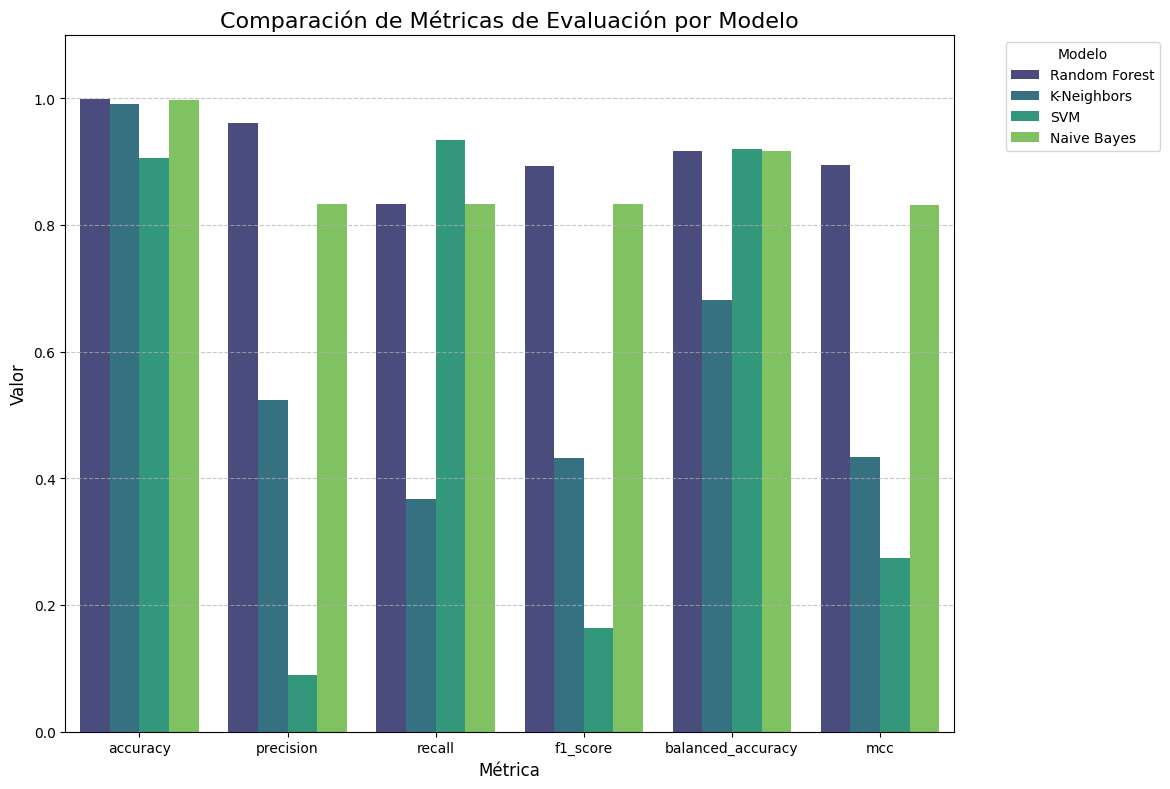

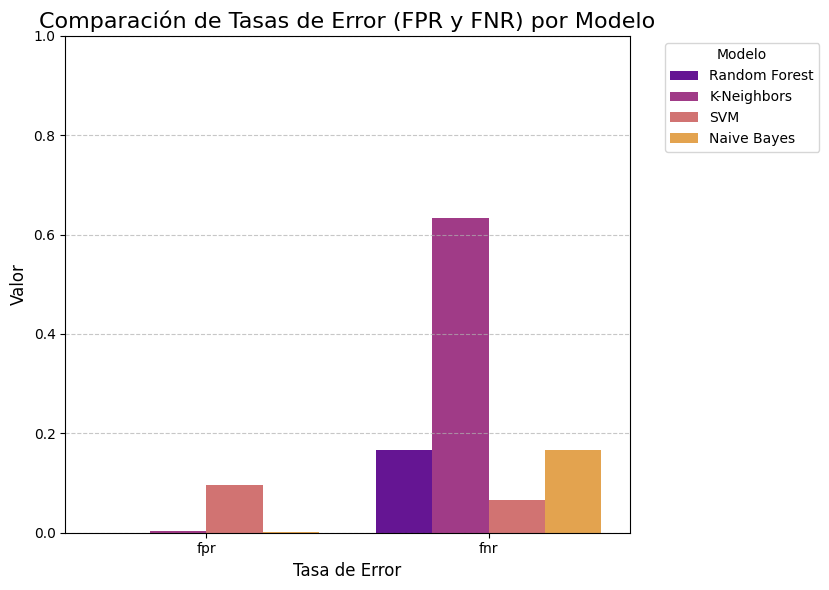


✅ Análisis y visualización completos terminados


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           matthews_corrcoef, confusion_matrix, classification_report)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

def generar_datos_fraude():
    """Genera dataset simulado de transacciones bancarias"""
    np.random.seed(42)

    total = 10000
    fraudes = 100
    legit = total - fraudes

    # Transacciones legítimas
    datos_legit = {
        'monto': np.random.lognormal(6, 1, legit),
        'frecuencia': np.random.poisson(2, legit),
        'hora': np.random.normal(12, 4, legit),
        'dia_semana': np.random.choice(range(7), legit),
        'edad_cuenta': np.random.exponential(365, legit),
        'es_fraude': np.zeros(legit)
    }

    # Transacciones fraudulentas
    datos_fraude = {
        'monto': np.random.lognormal(8, 2, fraudes),
        'frecuencia': np.random.poisson(5, fraudes),
        'hora': np.random.normal(2, 2, fraudes),
        'dia_semana': np.random.choice([5, 6], fraudes),
        'edad_cuenta': np.random.exponential(30, fraudes),
        'es_fraude': np.ones(fraudes)
    }

    # Combinar datos
    datos_final = {}
    for key in datos_legit.keys():
        datos_final[key] = np.concatenate([datos_legit[key], datos_fraude[key]])

    df = pd.DataFrame(datos_final)
    return df.sample(frac=1).reset_index(drop=True)

def calcular_metricas_detalladas(y_true, y_pred, nombre_modelo):
    """Calcula todas las métricas de evaluación para un modelo"""

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Métricas básicas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)

    # Métricas adicionales
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate

    # Balanced Accuracy
    balanced_acc = (recall + specificity) / 2

    return {
        'modelo': nombre_modelo,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,
        'npv': npv,
        'mcc': mcc,
        'balanced_accuracy': balanced_acc,
        'fpr': fpr,
        'fnr': fnr,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn
    }

def mostrar_metricas_completas(resultados_metricas):
    """Muestra todas las métricas de forma detallada"""

    print("📊 MÉTRICAS COMPLETAS DE EVALUACIÓN")
    print("=" * 80)

    # 1. Tabla de métricas principales
    print("\n1️⃣ MÉTRICAS PRINCIPALES")
    print("-" * 50)
    print(f"{'Modelo':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-" * 50)

    for resultado in resultados_metricas:
        print(f"{resultado['modelo']:<15} {resultado['accuracy']:<10.3f} "
              f"{resultado['precision']:<10.3f} {resultado['recall']:<10.3f} "
              f"{resultado['f1_score']:<10.3f}")

    # 2. Métricas avanzadas
    print("\n2️⃣ MÉTRICAS AVANZADAS")
    print("-" * 65)
    print(f"{'Modelo':<15} {'Specificity':<12} {'NPV':<10} {'MCC':<10} {'Bal.Acc':<10}")
    print("-" * 65)

    for resultado in resultados_metricas:
        print(f"{resultado['modelo']:<15} {resultado['specificity']:<12.3f} "
              f"{resultado['npv']:<10.3f} {resultado['mcc']:<10.3f} "
              f"{resultado['balanced_accuracy']:<10.3f}")

    # 3. Tasas de error
    print("\n3️⃣ TASAS DE ERROR")
    print("-" * 40)
    print(f"{'Modelo':<15} {'FPR':<10} {'FNR':<10}")
    print("-" * 40)

    for resultado in resultados_metricas:
        print(f"{resultado['modelo']:<15} {resultado['fpr']:<10.3f} "
              f"{resultado['fnr']:<10.3f}")

    # 4. Matriz de confusión para cada modelo
    print("\n4️⃣ MATRICES DE CONFUSIÓN")
    print("-" * 30)

    for resultado in resultados_metricas:
        print(f"\n🔍 {resultado['modelo']}")
        print(f"   Verdaderos Positivos (TP): {resultado['tp']}")
        print(f"   Verdaderos Negativos (TN): {resultado['tn']}")
        print(f"   Falsos Positivos (FP): {resultado['fp']}")
        print(f"   Falsos Negativos (FN): {resultado['fn']}")
        print(f"   Total predicciones correctas: {resultado['tp'] + resultado['tn']}")
        print(f"   Total predicciones incorrectas: {resultado['fp'] + resultado['fn']}")

def mostrar_interpretacion_metricas():
    """Muestra interpretación de cada métrica"""

    print("\n📖 INTERPRETACIÓN DE MÉTRICAS")
    print("=" * 50)

    interpretaciones = {
        "Accuracy": "Porcentaje de predicciones correctas del total",
        "Precision": "De las predicciones de fraude, cuántas fueron correctas",
        "Recall": "De todos los fraudes reales, cuántos fueron detectados",
        "F1-Score": "Media armónica entre precisión y recall",
        "Specificity": "De todas las transacciones legítimas, cuántas fueron correctamente clasificadas",
        "NPV": "De las predicciones de legítimas, cuántas fueron correctas",
        "MCC": "Coeficiente de correlación de Matthews (-1 a 1, mejor cerca de 1)",
        "Balanced Accuracy": "Promedio entre recall y specificity",
        "FPR": "Tasa de falsos positivos (alarmas falsas)",
        "FNR": "Tasa de falsos negativos (fraudes no detectados)"
    }

    for metrica, interpretacion in interpretaciones.items():
        print(f"• {metrica:<18}: {interpretacion}")

def analizar_rendimiento_por_modelo(resultados_metricas):
    """Analiza el rendimiento de cada modelo"""

    print("\n🎯 ANÁLISIS DE RENDIMIENTO")
    print("=" * 40)

    # Encontrar el mejor modelo para cada métrica
    mejor_accuracy = max(resultados_metricas, key=lambda x: x['accuracy'])
    mejor_precision = max(resultados_metricas, key=lambda x: x['precision'])
    mejor_recall = max(resultados_metricas, key=lambda x: x['recall'])
    mejor_f1 = max(resultados_metricas, key=lambda x: x['f1_score'])

    print(f"🏆 Mejor Accuracy: {mejor_accuracy['modelo']} ({mejor_accuracy['accuracy']:.3f})")
    print(f"🎯 Mejor Precision: {mejor_precision['modelo']} ({mejor_precision['precision']:.3f})")
    print(f"🔍 Mejor Recall: {mejor_recall['modelo']} ({mejor_recall['recall']:.3f})")
    print(f"⚖️  Mejor F1-Score: {mejor_f1['modelo']} ({mejor_f1['f1_score']:.3f})")

    # Análisis de trade-offs
    print("\n📊 ANÁLISIS DE TRADE-OFFS")
    print("-" * 30)

    for resultado in resultados_metricas:
        modelo = resultado['modelo']
        precision = resultado['precision']
        recall = resultado['recall']
        fpr = resultado['fpr']

        print(f"\n{modelo}:")

        if precision > 0.8 and recall > 0.8:
            print("   ✅ Excelente balance precision-recall")
        elif precision > 0.8:
            print("   🎯 Alta precisión (pocas alarmas falsas)")
        elif recall > 0.8:
            print("   🔍 Alto recall (detecta la mayoría de fraudes)")
        else:
            print("   ⚠️  Necesita mejora en precision y/o recall")

        if fpr < 0.01:
            print("   ✅ Muy pocas alarmas falsas")
        elif fpr < 0.05:
            print("   👍 Alarmas falsas aceptables")
        else:
            print("   ❌ Demasiadas alarmas falsas")

def graficar_metricas_comparacion(resultados_metricas):
    """Genera gráficos comparativos de las métricas de evaluación para diferentes modelos."""

    # Convertir la lista de diccionarios a un DataFrame para facilitar la graficación
    df_metricas = pd.DataFrame(resultados_metricas)
    df_metricas = df_metricas.set_index('modelo') # Usar el nombre del modelo como índice

    # Seleccionar las métricas clave para graficar
    metricas_clave = ['accuracy', 'precision', 'recall', 'f1_score', 'balanced_accuracy', 'mcc']
    df_metricas_clave = df_metricas[metricas_clave]

    # Reorganizar los datos para un gráfico de barras agrupadas
    df_metricas_melted = df_metricas_clave.reset_index().melt(
        id_vars='modelo', var_name='metrica', value_name='valor'
    )

    plt.figure(figsize=(14, 8))
    sns.barplot(data=df_metricas_melted, x='metrica', y='valor', hue='modelo', palette='viridis')

    plt.title('Comparación de Métricas de Evaluación por Modelo', fontsize=16)
    plt.xlabel('Métrica', fontsize=12)
    plt.ylabel('Valor', fontsize=12)
    plt.ylim(0, 1.1) # Establecer el límite superior para métricas entre 0 y 1
    plt.xticks(rotation=0) # Rotación de 0 grados para las métricas

    # Ajustar la leyenda
    plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajustar para dejar espacio para la leyenda
    plt.show()

    # Gráfico de tasas de error (FPR y FNR)
    metricas_error = ['fpr', 'fnr']
    df_metricas_error = df_metricas[metricas_error]
    df_metricas_error_melted = df_metricas_error.reset_index().melt(
        id_vars='modelo', var_name='metrica', value_name='valor'
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_metricas_error_melted, x='metrica', y='valor', hue='modelo', palette='plasma')

    plt.title('Comparación de Tasas de Error (FPR y FNR) por Modelo', fontsize=16)
    plt.xlabel('Tasa de Error', fontsize=12)
    plt.ylabel('Valor', fontsize=12)
    plt.ylim(0, 1.0) # Ajustar límite si las tasas de error son altas
    plt.xticks(rotation=0)

    # Ajustar la leyenda
    plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


def main():
    """Función principal con análisis detallado de métricas y gráficos."""

    print("🏦 ANÁLISIS DETALLADO DE MÉTRICAS Y GRÁFICOS - DETECTOR DE FRAUDE")
    print("=" * 70)

    # Generar datos
    df = generar_datos_fraude()
    X = df.drop('es_fraude', axis=1)
    y = df['es_fraude']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Modelos a evaluar
    modelos = {
        'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced'),
        'K-Neighbors': KNeighborsClassifier(n_neighbors=5),
        'SVM': SVC(kernel='rbf', random_state=42, class_weight='balanced', probability=True), # probability=True para predict_proba si es necesario
        'Naive Bayes': GaussianNB()
    }

    # Entrenar y evaluar cada modelo
    resultados_metricas = []

    print("\n🔍 Entrenando y evaluando modelos...")

    for nombre, modelo in modelos.items():
        print(f"   Procesando {nombre}...")

        # Entrenar
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # Calcular métricas
        metricas = calcular_metricas_detalladas(y_test, y_pred, nombre)
        resultados_metricas.append(metricas)

    # Mostrar resultados detallados
    mostrar_metricas_completas(resultados_metricas)

    # Mostrar interpretación
    mostrar_interpretacion_metricas()

    # Análisis de rendimiento
    analizar_rendimiento_por_modelo(resultados_metricas)

    # Generar gráficos comparativos
    print("\n📈 Generando gráficos de métricas...")
    graficar_metricas_comparacion(resultados_metricas)

    print("\n" + "="*70)
    print("✅ Análisis y visualización completos terminados")

if __name__ == "__main__":
    main()